<a href="https://colab.research.google.com/github/sahil3Vedi/Engine-Sound-Classification/blob/master/Automobile_Classification_Using_Engine_Sound.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip3 install pydub

In [0]:
# Step 1: Import Dependencies
from google.colab import drive
drive.mount('/content/drive')
import os
from pydub import AudioSegment
import matplotlib.pyplot as plt
from scipy.io import wavfile as wav
from scipy.fftpack import fft
import numpy as np
import pandas as pd

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import model_selection, metrics
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score , classification_report, mean_squared_error, r2_score
from sklearn.metrics import precision_score, recall_score, accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import *
from sklearn import metrics
from sklearn.utils import shuffle

from scipy.spatial import distance

In [0]:
# Step 2: Load Data into Project
DATA_DIR = 'drive/My Drive/Engine Data'
number_samples = 60
df_list = []
categories = []

for each_name in os.listdir(DATA_DIR):
  AUDIO_FILE = os.path.join(DATA_DIR,each_name)
  rate, data = wav.read(AUDIO_FILE)
  categories.append(each_name[:-4])

  for counter in range(number_samples):
    tempdict = {}
    newAudio = data[counter*500:(counter+1)*500]
    fft_out = np.abs(fft(newAudio), dtype = float)
    fft_norm1 = np.mean(fft_out)
    fft_norm2 = np.std(fft_out)
    fft_label = each_name[:-4]
    tempdict["FFT"] = fft_norm1
    tempdict["Norm"] = fft_norm2
    tempdict["label"] = fft_label
    df_list.append(tempdict) 

df = pd.DataFrame(df_list)  

In [5]:
df.head()

,FFT,Norm,label
0,1.001177e+06,5.416206e+05,Skoda_Yeti
1,1.284359e+08,1.042747e+08,Skoda_Yeti
2,3.069598e+08,2.412794e+08,Skoda_Yeti
3,4.867208e+08,4.421068e+08,Skoda_Yeti
4,6.626031e+08,4.884486e+08,Skoda_Yeti


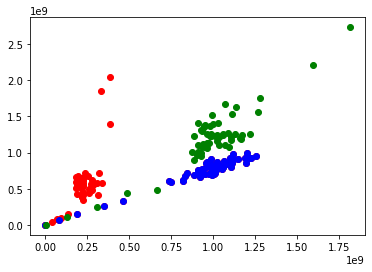

In [6]:
axis1 = df["FFT"][60:]
axis2 = df["Norm"][60:]
axis3 = df["FFT"][60:120]
axis4 = df["Norm"][60:120]
axis5 = df["FFT"][:60]
axis6 = df["Norm"][:60]

plt.plot(axis1, axis2, 'ro')
plt.plot(axis3, axis4, 'bo')
plt.plot(axis5, axis6, 'go')

In [0]:
# Step 3: Generate Training and Testing Set with Labels
df = shuffle(df)
df.reset_index(inplace=True, drop=True)

features=list(df.columns)
features.remove('label')
X = df[features]
y = df['label']

# split dataset to 60% training and 40% testing
X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y, test_size=0.4, random_state=0)

In [8]:
print(X_train.shape, y_train.shape)

(108, 2) (108,)


In [9]:
# Step 4: Model Selection: Linear Vector Quantisation

#obtaining initial weights
weights = []
category_names = []
temp_categories = categories
for i, j in df.iterrows():
  if(len(temp_categories)>0):
    category_label = j['label']
    if category_label in temp_categories:
      temp_categories.remove(category_label)
      sample_FFT = j['FFT']
      sample_Norm = j['Norm']
      temp_weight = [sample_FFT,sample_Norm]
      weights.append(temp_weight)
      category_names.append(category_label)
  else:
    continue

print(weights)

#training the weight vectors iteratively
total_samples = (len(category_names)*number_samples)-len(category_names)
training_sample_max_index = int(np.floor(total_samples*0.6))
learning_rate = 0.1
epochs = 50
for epoch_counter in range(epochs):
  for k in range(0, training_sample_max_index):
    selected_sample = df.loc[k]
    samp_mean = selected_sample['FFT']
    samp_std = selected_sample['Norm']
    samp_label = selected_sample['label']
    sample_weight = [samp_mean,samp_std]
    distances = []
    for each_weight in weights:
      eucl_dist = distance.euclidean(each_weight, sample_weight)
      distances.append(eucl_dist)
    min_distance = min(distances)
    sample_min_dist_index = distances.index(min_distance)
    weight_index = category_names.index(samp_label)
    W = weights[weight_index]
    Q = np.subtract(sample_weight,W)
    R = np.multiply(learning_rate,Q)
    if(sample_min_dist_index==weight_index):
      weights[weight_index] = np.add(W,R)
    else:
      weights[weight_index] = np.subtract(W,R)

print(weights)
        


[[1158871097.793477, 1202486396.4555311], [36802641.384849794, 40674339.61867822], [0.0, 0.0]]
[array([1.11997651e+09, 1.38949718e+09]), array([2.17670536e+08, 5.27030004e+08]), array([-3.94253601e+87, -3.09983422e+87])]


In [0]:
# Step 5: Comparing Results